# KO guide distributions


In [34]:
from libraries import *
from parameters import *

from statsmodels.stats.proportion import proportions_ztest
import statsmodels.stats.multitest as smm

In [35]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [36]:
os.getcwd()
os.chdir(projectDir)

In [37]:
adata = sc.read("outputs/anndata/adata-hash-features_singlets_SingleKO_05242020.h5ad")

In [38]:
adata.X.shape

(341664, 13811)

In [39]:
fBarMat = adata.obs[adata.uns['feature_barcode_names']]
fBarMat.shape

(341664, 3720)

In [40]:
fBarMat[fBarMat > 0] = 1

/tmp/ipykernel_27392/3551141962.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fBarMat[fBarMat > 0] = 1
/tmp/ipykernel_27392/3551141962.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fBarMat[fBarMat > 0] = 1


In [41]:
fBarMatMulti = fBarMat.loc[fBarMat.sum(axis=1) > 1,]
fBarMatMulti.shape

(0, 3720)

In [42]:
fBarMat = fBarMat.loc[fBarMat.sum(axis=1) == 1,]
fBarMat.shape

(341664, 3720)

In [43]:
guideList = fBarMat.columns

In [44]:
k = [x.startswith("ONE_NONGENE_SITE_") for x in guideList]
nonGeneGuides = fBarMat.loc[:,k]
nonGeneGuides = nonGeneGuides.loc[nonGeneGuides.sum(axis=1) == 1,:]
nonGeneGuides.shape

(18663, 165)

In [45]:
cellsPersNonGeneGuides = nonGeneGuides.sum(axis=0)
cellsPersNonGeneGuides[cellsPersNonGeneGuides == 0]

ONE_NONGENE_SITE_211    0
dtype: int64

In [46]:
l = [x.startswith("NO_TARGET_") for x in guideList]
noTargetGuides = fBarMat.loc[:,l]
noTargetGuides = noTargetGuides.loc[noTargetGuides.sum(axis=1) == 1,:]
noTargetGuides.shape

(25411, 165)

In [47]:
cellsPerNoTargetGuides = noTargetGuides.sum(axis=0)
cellsPerNoTargetGuides[cellsPerNoTargetGuides == 0]

Series([], dtype: int64)

In [48]:
g = [(not(x.startswith("ONE_NONGENE_SITE_") or x.startswith("NO_TARGET_")) )for x in guideList]
geneGuides = fBarMat.loc[:,g]
geneGuides = geneGuides.loc[geneGuides.sum(axis=1) == 1,:]
geneGuides.shape

(297590, 3390)

In [49]:
cellsPerKOGuides = geneGuides.sum(axis=0)
cellsPerKOGuides[cellsPerKOGuides == 0]

Lonrf2_3    0
Trim3_3     0
Ret_3       0
dtype: int64

In [50]:
poolSummary = pd.read_csv('./PositiveControls/GuidePoolSummary_2.csv', sep="\\," )
poolSummary.columns = ["Guide", "nCellsPool"]
poolSummary["nCellsPool"] = poolSummary["nCellsPool"].astype(int)
poolSummary["Guide"] = poolSummary["Guide"].replace('-', '_', regex=True)
poolSummary

/tmp/ipykernel_27392/1127726213.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  poolSummary = pd.read_csv('./PositiveControls/GuidePoolSummary_2.csv', sep="\\," )


,Guide,nCellsPool
0,March1_1,600
1,March1_2,504
2,March1_3,656
3,March2_1,592
4,March2_2,300
...,...,...
3715,Zpbp2_2,484
3716,Zpbp2_3,448
3717,Zswim2_1,320
3718,Zswim2_2,428


In [51]:
k1 = pd.DataFrame(nonGeneGuides.sum(axis=0), columns=["nCellsScreen"])
k1["Guide"] = k1.index
k1

k2 = pd.DataFrame(noTargetGuides.sum(axis=0), columns=["nCellsScreen"])
k2["Guide"] = k2.index
k2

k3 = pd.DataFrame(geneGuides.sum(axis=0), columns=["nCellsScreen"])
k3["Guide"] = k3.index
k3

k = k1.append(k2)
k = k.append(k3)

/tmp/ipykernel_27392/3382385161.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  k = k1.append(k2)
/tmp/ipykernel_27392/3382385161.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  k = k.append(k3)


In [52]:
k

,nCellsScreen,Guide
ONE_NONGENE_SITE_166,157,ONE_NONGENE_SITE_166
ONE_NONGENE_SITE_167,283,ONE_NONGENE_SITE_167
ONE_NONGENE_SITE_168,111,ONE_NONGENE_SITE_168
ONE_NONGENE_SITE_169,193,ONE_NONGENE_SITE_169
ONE_NONGENE_SITE_170,112,ONE_NONGENE_SITE_170
...,...,...
Socs2_2,80,Socs2_2
Socs2_3,38,Socs2_3
Gm9847_1,94,Gm9847_1
Gm9847_2,86,Gm9847_2


In [53]:
poolSummary['Guide'] = poolSummary['Guide'].str.replace('Rnf8_cmtr1','Rnf8-cmtr1')
poolSummary['Guide'] = poolSummary['Guide'].str.replace('Siah1_ps1','Siah1-ps1')
poolSummary['Guide'] = poolSummary['Guide'].str.replace('Siah1_ps2','Siah1-ps2')

In [54]:
poolSummary.Guide[~poolSummary.Guide.isin(k.Guide)]

888    Fullstats
Name: Guide, dtype: object

In [55]:
k.Guide[~k.Guide.isin(poolSummary.Guide)]

ONE_NONGENE_SITE_330    ONE_NONGENE_SITE_330
Name: Guide, dtype: object

In [56]:
result = pd.merge(poolSummary, k, on="Guide")
result["type"] = "Gene"

l = [x.startswith("NO_TARGET_") for x in result["Guide"]]
result.loc[l,"type"] = "Control_NO_TARGET"
l = [x.startswith("ONE_NONGENE_SITE") for x in result["Guide"]]
result.loc[l,"type"] = "Control_ONE_NON_GENE_SITE"

In [57]:
resultGeneLev = result.copy()
resultGeneLev["targetGene"] = ['_'.join(x.split("_")[:-1]) for x in resultGeneLev.Guide]
resultGeneLev = resultGeneLev.groupby("targetGene").sum()
resultGeneLev = resultGeneLev.drop('ONE_NONGENE_SITE')
resultGeneLev = resultGeneLev.drop('NO_TARGET')

In [58]:
resultGeneLev

,nCellsPool,nCellsScreen
targetGene,,
4921501E09Rik,1824,309
4930595M18Rik,1900,449
8030462N17Rik,1384,68
Aamp,1064,89
Abtb1,1308,224
...,...,...
Znrf2,1604,287
Znrf3,1440,153
Znrf4,1460,197


297590
(3390, 4)
78.0
18326
106.5
25411
146.0


[Text(0.5, 0, 'Number of cells per control no-target guide')]

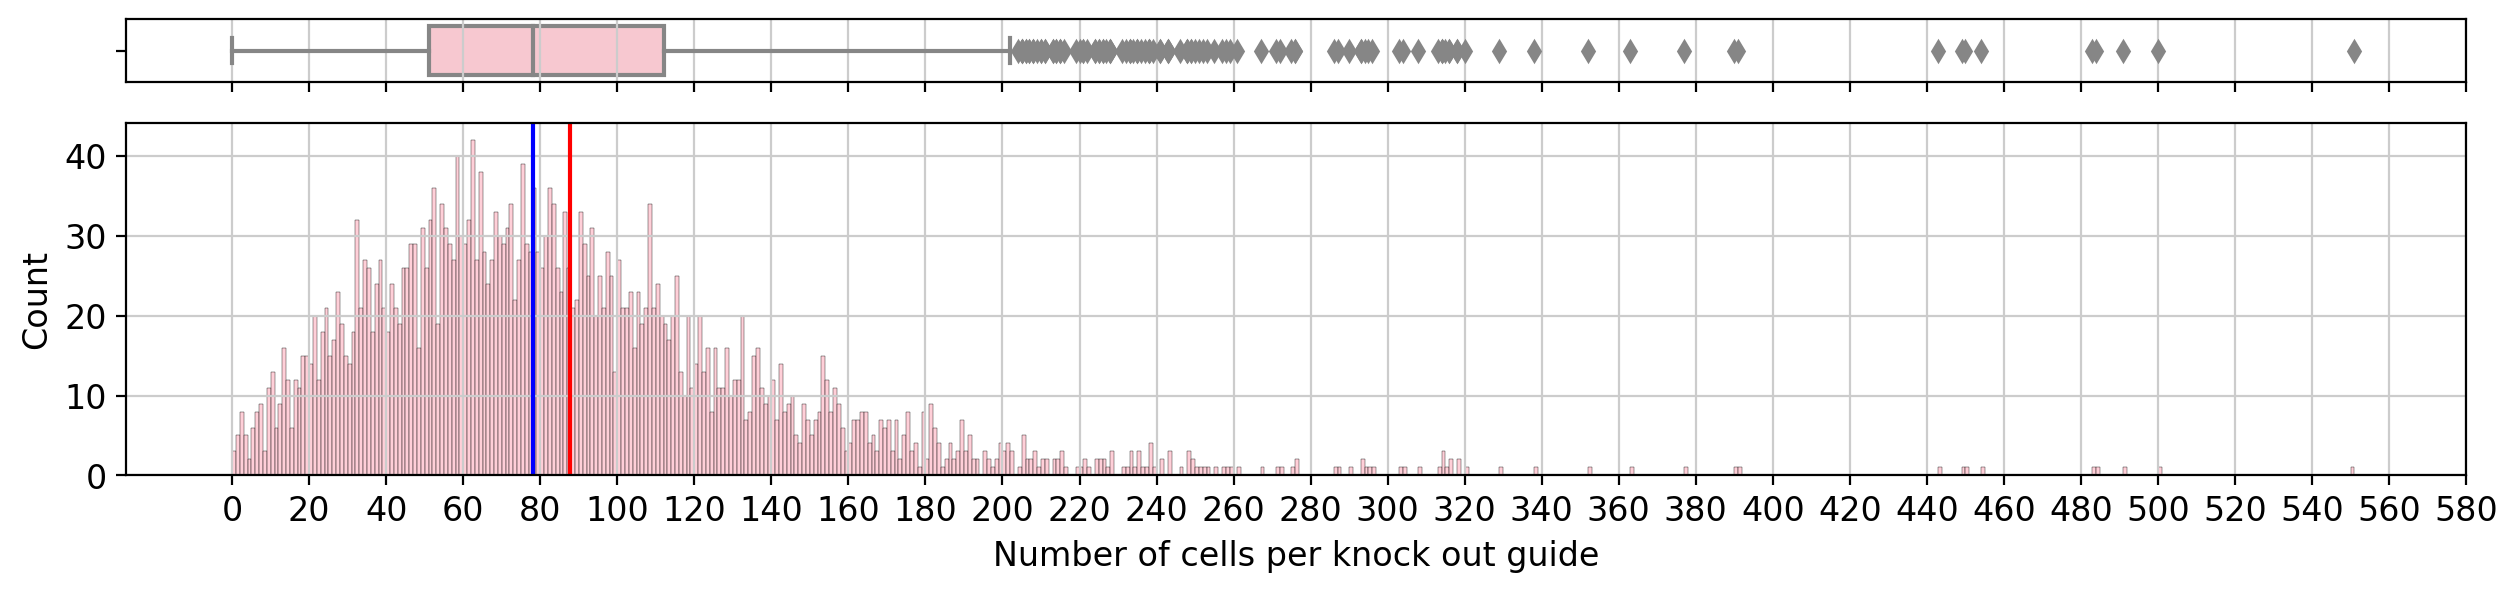

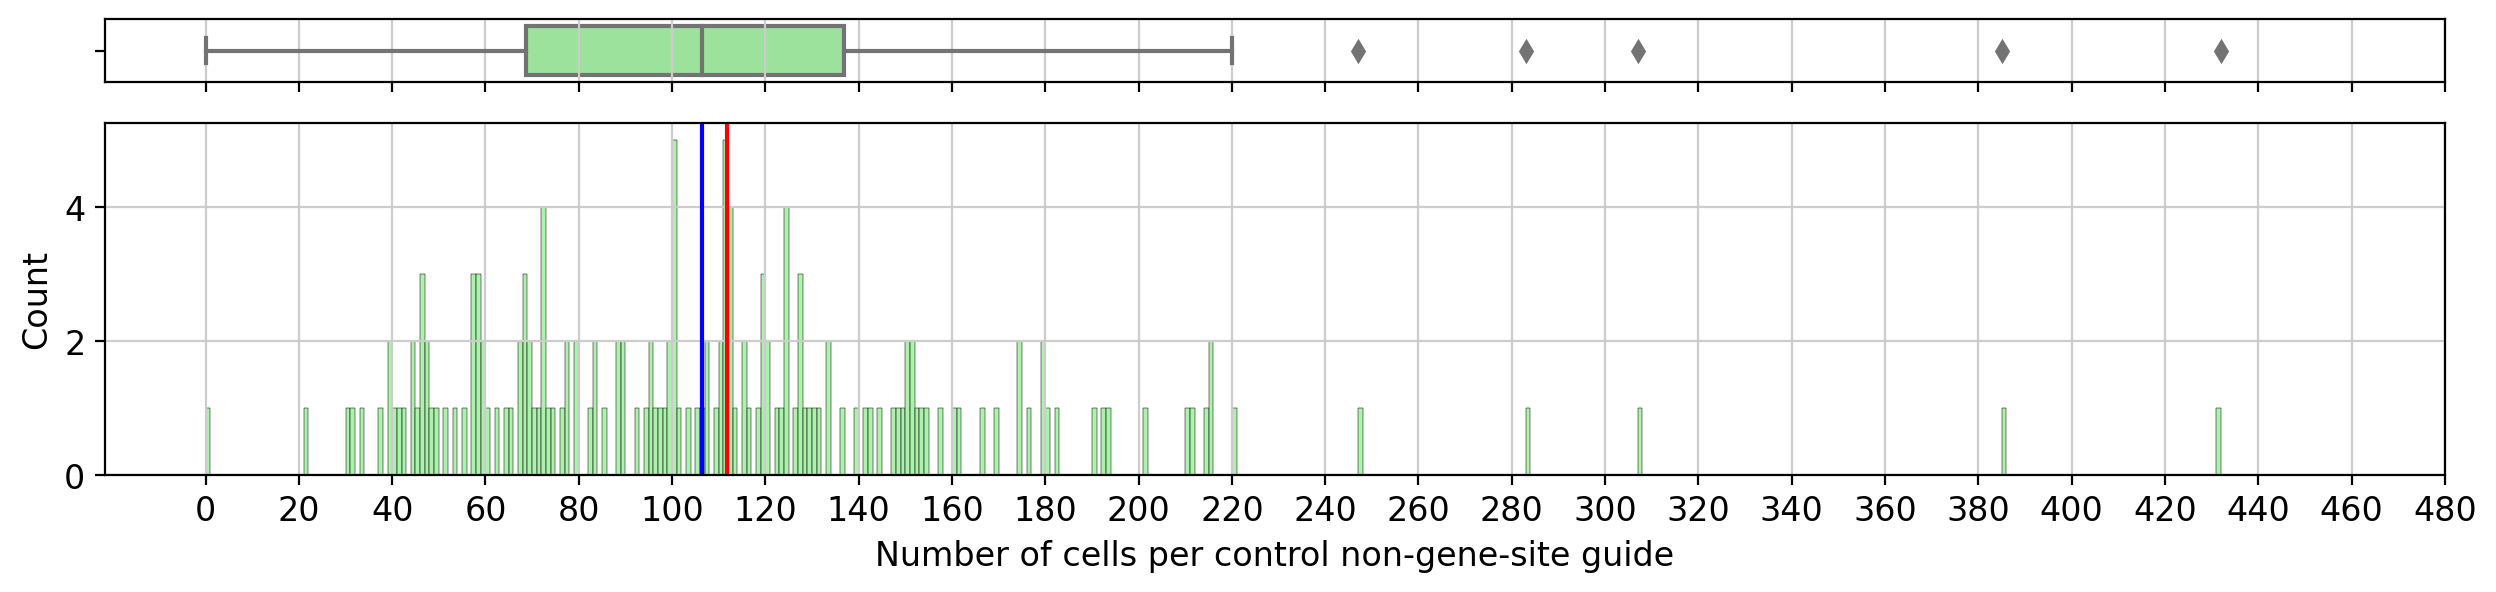

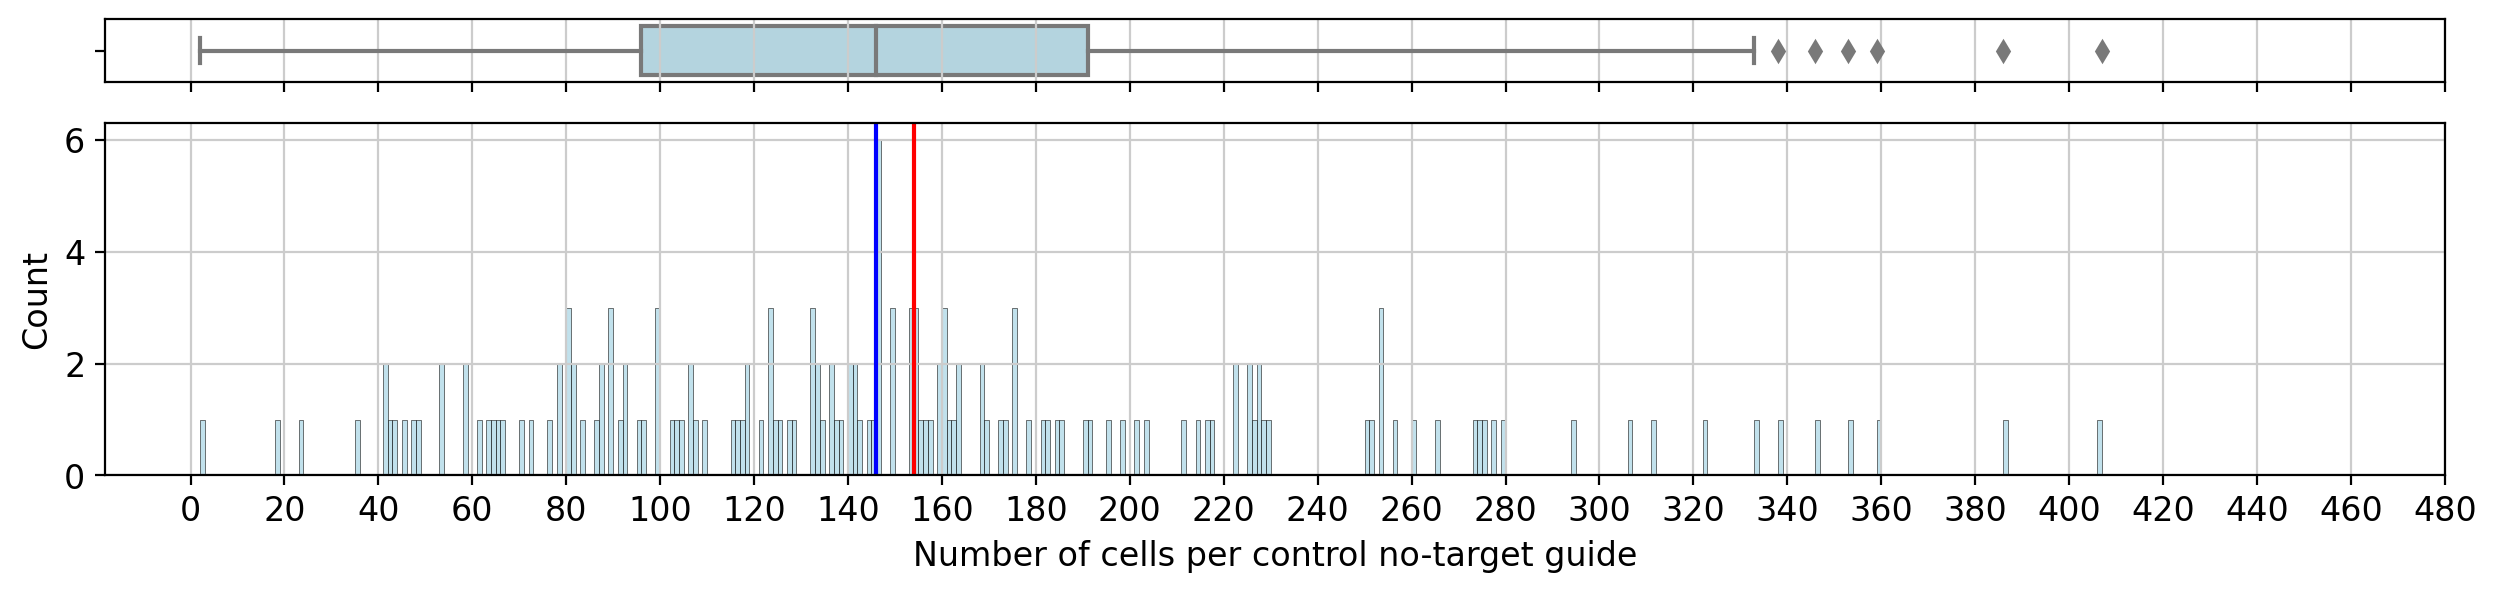

In [59]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(15, 3))
 
# Add a graph in each part
kGene = result.loc[result.type == "Gene",:]
print(kGene.nCellsScreen.sum())
print(kGene.shape)
print(kGene.nCellsScreen.median())
sns.boxplot(data = kGene, x= 'nCellsScreen', ax=ax_box, color="pink")
sns.histplot(data = kGene, x = 'nCellsScreen', ax=ax_hist, color="pink", binwidth=1)
ax_hist.set_xticks(range(0,600,20))
ax_hist.set_xticklabels(range(0,600,20))
plt.axvline(x=kGene.nCellsScreen.mean(),
            color='red')
plt.axvline(x=kGene.nCellsScreen.median(),
            color='blue')
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
ax_hist.set(xlabel="Number of cells per knock out guide")


f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(15, 3))
 
# Add a graph in each part
kControlNonGene = result.loc[result.type == "Control_ONE_NON_GENE_SITE",:]
print(kControlNonGene.nCellsScreen.sum())
print(kControlNonGene.nCellsScreen.median())
sns.boxplot(data = kControlNonGene,x= 'nCellsScreen', ax=ax_box, color="lightgreen")
sns.histplot(data = kControlNonGene,x = 'nCellsScreen', ax=ax_hist, color="lightgreen", binwidth=1)
ax_hist.set_xticks(range(0,500,20))
ax_hist.set_xticklabels(range(0,500,20))
plt.axvline(x=kControlNonGene.nCellsScreen.mean(),
            color='red')
plt.axvline(x=kControlNonGene.nCellsScreen.median(),
            color='blue')
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
ax_hist.set(xlabel="Number of cells per control non-gene-site guide")


f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(15, 3))
 
# Add a graph in each part
kControlNoTarget = result.loc[result.type == "Control_NO_TARGET",:]
print(kControlNoTarget.nCellsScreen.sum())
print(kControlNoTarget.nCellsScreen.median())
sns.boxplot(data = kControlNoTarget,x= 'nCellsScreen', ax=ax_box, color="lightblue")
sns.histplot(data = kControlNoTarget,x = 'nCellsScreen', ax=ax_hist, color="lightblue", binwidth=1)
ax_hist.set_xticks(range(0,500,20))
ax_hist.set_xticklabels(range(0,500,20))
plt.axvline(x=kControlNoTarget.nCellsScreen.mean(),
            color='red')
plt.axvline(x=kControlNoTarget.nCellsScreen.median(),
            color='blue')
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
ax_hist.set(xlabel="Number of cells per control no-target guide")



In [60]:
totalScreen = sum(resultGeneLev.nCellsScreen)
totalGuidePool = sum(resultGeneLev.nCellsPool)

resultGeneLev["nCellsPoolPerc"] = resultGeneLev.nCellsPool / totalGuidePool
resultGeneLev["nCellsScreenPerc"] = resultGeneLev.nCellsScreen / totalScreen
resultGeneLev["nCellsScreenPoolPercDif"] = resultGeneLev["nCellsScreenPerc"] - resultGeneLev["nCellsPoolPerc"]

resultGeneLev = resultGeneLev.sort_values('nCellsScreenPerc')
resultGeneLev

,nCellsPool,nCellsScreen,nCellsPoolPerc,nCellsScreenPerc,nCellsScreenPoolPercDif
targetGene,,,,,
Gnb4,1356,26,0.000811,0.000087,-0.000723
Mdm2,1880,30,0.001124,0.000101,-0.001023
Cdc20,1232,34,0.000736,0.000114,-0.000622
Gm3701,1380,61,0.000825,0.000205,-0.000620
Enc1,560,67,0.000335,0.000225,-0.000110
...,...,...,...,...,...
Klhl6,1992,652,0.001191,0.002191,0.001000
Fbxo42,1752,660,0.001047,0.002218,0.001171
Gm18856,1344,671,0.000803,0.002255,0.001451


<AxesSubplot:xlabel='nCellsScreenPoolPercDif'>

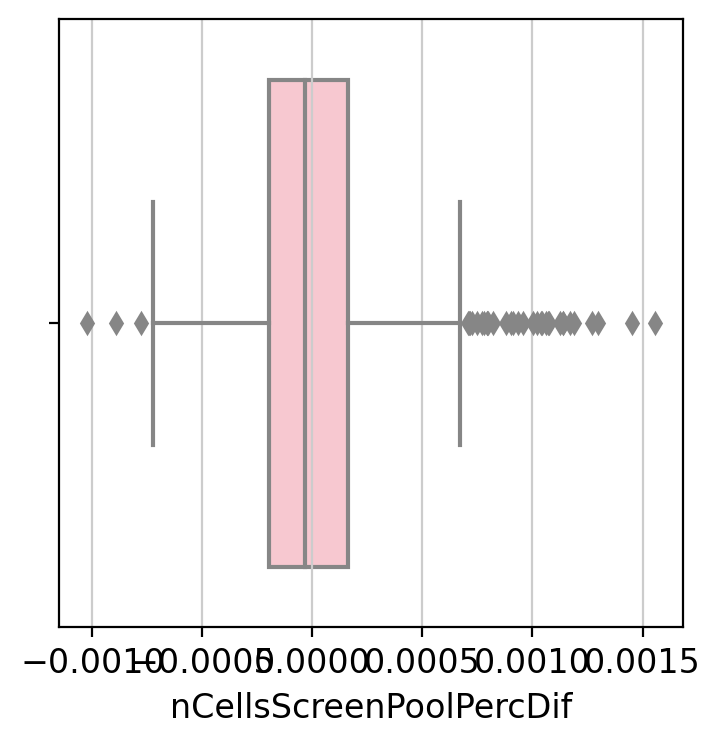

In [61]:
sns.boxplot(data = resultGeneLev, x= 'nCellsScreenPoolPercDif', color="pink")


In [62]:
resultGeneLev["statLarger"] = 0
resultGeneLev["pValLarger"] = 0
resultGeneLev["statSmaller"] = 0
resultGeneLev["pValSmaller"] = 0

for i in range(0,resultGeneLev.shape[0]):
    count = np.array([resultGeneLev["nCellsPool"].iat[i], resultGeneLev["nCellsScreen"].iat[i]])
    nobs = np.array([totalGuidePool, totalScreen])
    stat1, pval1 = proportions_ztest(count, nobs, alternative = "larger" )
    resultGeneLev["statLarger"].iat[i] = stat1
    resultGeneLev["pValLarger"].iat[i] = pval1
    
    stat2, pval2 = proportions_ztest(count, nobs, alternative = "smaller" )
    resultGeneLev["statSmaller"].iat[i] = stat2
    resultGeneLev["pValSmaller"].iat[i] = pval2

In [63]:
resultGeneLev["FDR_larger"] = smm.multipletests(resultGeneLev.pValLarger, method='fdr_bh')[1]
resultGeneLev["FDR_smaller"] = smm.multipletests(resultGeneLev.pValSmaller, method='fdr_bh')[1]

In [64]:
resultGeneLev.to_csv("NoOfCellsPerGuide_GeneLevel.csv")

In [65]:
resultGeneLev.loc[resultGeneLev.FDR_larger < 0.1,]

,nCellsPool,nCellsScreen,nCellsPoolPerc,nCellsScreenPerc,nCellsScreenPoolPercDif,statLarger,pValLarger,statSmaller,pValSmaller,FDR_larger,FDR_smaller
targetGene,,,,,,,,,,,
Gnb4,1356,26,0.000811,0.000087,-0.000723,13.730857,3.317202e-43,13.730857,1.000000,1.249480e-40,1.0
Mdm2,1880,30,0.001124,0.000101,-0.001023,16.523617,1.240316e-61,16.523617,1.000000,1.401557e-58,1.0
Cdc20,1232,34,0.000736,0.000114,-0.000622,12.342113,2.686365e-35,12.342113,1.000000,6.071185e-33,1.0
Gm3701,1380,61,0.000825,0.000205,-0.000620,11.526906,4.827605e-31,11.526906,1.000000,6.818993e-29,1.0
Enc1,560,67,0.000335,0.000225,-0.000110,3.088879,1.004568e-03,3.088879,0.998995,3.661812e-03,1.0
...,...,...,...,...,...,...,...,...,...,...,...
Wdr55,2328,310,0.001392,0.001042,-0.000350,4.809676,7.558763e-07,4.809676,0.999999,4.693078e-06,1.0
Dpy19l2,2088,311,0.001248,0.001045,-0.000203,2.926914,1.711717e-03,2.926914,0.998288,6.048422e-03,1.0
Lrrc55,2164,311,0.001294,0.001045,-0.000248,3.526400,2.106251e-04,3.526400,0.999789,8.847822e-04,1.0


In [66]:
resultGeneLev.loc[resultGeneLev.FDR_smaller < 0.1,]

,nCellsPool,nCellsScreen,nCellsPoolPerc,nCellsScreenPerc,nCellsScreenPoolPercDif,statLarger,pValLarger,statSmaller,pValSmaller,FDR_larger,FDR_smaller
targetGene,,,,,,,,,,,
Dennd3,856,192,0.000512,0.000645,0.000134,-2.910529,0.998196,-2.910529,1.804085e-03,1.0,7.578500e-03
Wdr5b,776,195,0.000464,0.000655,0.000191,-4.335069,0.999993,-4.335069,7.285731e-06,1.0,4.474389e-05
Smyd1,948,202,0.000567,0.000679,0.000112,-2.333341,0.990185,-2.333341,9.815117e-03,1.0,3.532192e-02
Ddx58,936,202,0.000560,0.000679,0.000119,-2.495679,0.993714,-2.495679,6.285817e-03,1.0,2.367658e-02
Spsb4,996,205,0.000595,0.000689,0.000094,-1.904251,0.971561,-1.904251,2.843877e-02,1.0,9.341806e-02
...,...,...,...,...,...,...,...,...,...,...,...
Klhl6,1992,652,0.001191,0.002191,0.001000,-13.733938,1.000000,-13.733938,3.179089e-43,1.0,1.890721e-41
Fbxo42,1752,660,0.001047,0.002218,0.001171,-16.827224,1.000000,-16.827224,7.708097e-64,1.0,1.088769e-61
Gm18856,1344,671,0.000803,0.002255,0.001451,-22.825317,1.000000,-22.825317,1.285322e-115,1.0,7.262067e-113


In [67]:
allRes = pd.DataFrame()

k = nonGeneGuides.sum(axis=0)
k = k[k!=0].index

for x in np.array(k):
    k = pd.DataFrame(pd.crosstab(index=nonGeneGuides[x], columns=adata.obs['leiden']).iloc[1,:] )
    k['leiden'] = k.index
    k['type'] = "Non-Gene"
    k['Guide_name'] = x
    allRes = allRes.append(k)

/tmp/ipykernel_27392/2938073188.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allRes = allRes.append(k)
/tmp/ipykernel_27392/2938073188.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allRes = allRes.append(k)
/tmp/ipykernel_27392/2938073188.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allRes = allRes.append(k)
/tmp/ipykernel_27392/2938073188.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allRes = allRes.append(k)
/tmp/ipykernel_27392/2938073188.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allRes = allRes.append(k)


In [68]:
allRes

,1,leiden,type,Guide_name
leiden,,,,
0,38,0,Non-Gene,ONE_NONGENE_SITE_166
1,37,1,Non-Gene,ONE_NONGENE_SITE_166
2,40,2,Non-Gene,ONE_NONGENE_SITE_166
3,18,3,Non-Gene,ONE_NONGENE_SITE_166
4,5,4,Non-Gene,ONE_NONGENE_SITE_166
...,...,...,...,...
5,5,5,Non-Gene,ONE_NONGENE_SITE_330
6,9,6,Non-Gene,ONE_NONGENE_SITE_330
7,8,7,Non-Gene,ONE_NONGENE_SITE_330


In [69]:
l = noTargetGuides.sum(axis=0)
l = l[l!=0].index


for x in np.array(l):
    k = pd.DataFrame(pd.crosstab(index=noTargetGuides[x], columns=adata.obs['leiden']).iloc[1,:] )
    k['leiden'] = k.index
    k['type'] = "No-Target"
    k['Guide_name'] = x
    allRes = allRes.append(k)

/tmp/ipykernel_27392/4082435738.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allRes = allRes.append(k)
/tmp/ipykernel_27392/4082435738.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allRes = allRes.append(k)
/tmp/ipykernel_27392/4082435738.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allRes = allRes.append(k)
/tmp/ipykernel_27392/4082435738.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allRes = allRes.append(k)
/tmp/ipykernel_27392/4082435738.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allRes = allRes.append(k)


In [70]:
g = geneGuides.sum(axis=0)
g = g[g!=0].index


for x in np.array(g):
    k = pd.DataFrame(pd.crosstab(index=geneGuides[x], columns=adata.obs['leiden']).iloc[1,:] )
    k['leiden'] = k.index
    k['type'] = "Gene"
    k['Guide_name'] = x
    allRes = allRes.append(k)

/tmp/ipykernel_27392/705279208.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allRes = allRes.append(k)
/tmp/ipykernel_27392/705279208.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allRes = allRes.append(k)
/tmp/ipykernel_27392/705279208.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allRes = allRes.append(k)
/tmp/ipykernel_27392/705279208.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allRes = allRes.append(k)
/tmp/ipykernel_27392/705279208.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allRes = allRes.append(k)
/tmp/

In [71]:
allRes

,1,leiden,type,Guide_name
leiden,,,,
0,38,0,Non-Gene,ONE_NONGENE_SITE_166
1,37,1,Non-Gene,ONE_NONGENE_SITE_166
2,40,2,Non-Gene,ONE_NONGENE_SITE_166
3,18,3,Non-Gene,ONE_NONGENE_SITE_166
4,5,4,Non-Gene,ONE_NONGENE_SITE_166
...,...,...,...,...
5,8,5,Gene,Gm9847_3
6,2,6,Gene,Gm9847_3
7,1,7,Gene,Gm9847_3


In [72]:
allRes["counts"] = allRes[1].astype(int)
allRes = allRes.reset_index(drop=True)

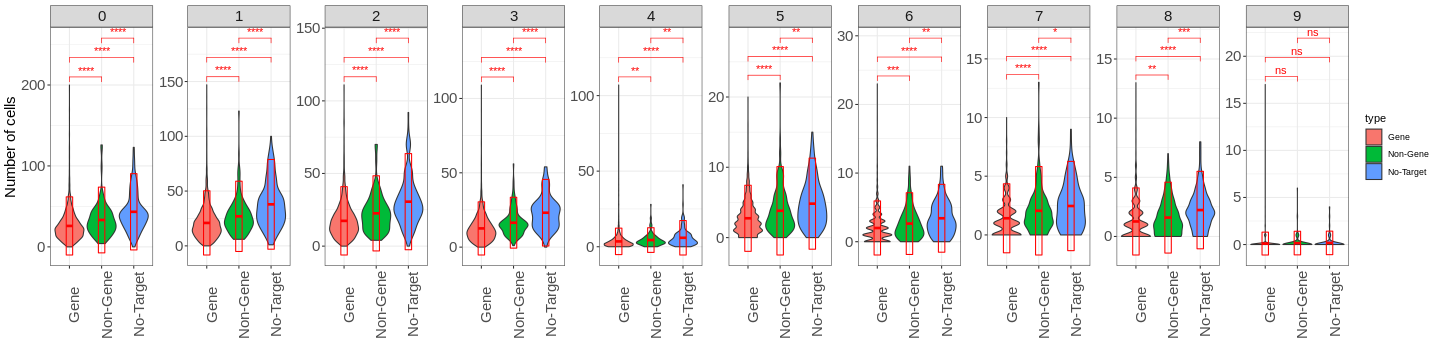

In [73]:
%%R -i allRes -w 20 -h 5 -u in

library(ggplot2)
library(ggpubr)

allRes$type = factor(allRes$type, levels=c("Gene", "Non-Gene", "No-Target"))

cList=list(c("Gene", "Non-Gene"), c("Gene", "No-Target"), c("Non-Gene", "No-Target"))

#allRes <- allRes[allRes$leiden %in% c("3", "4", "8"),]

k <- ggplot(allRes, aes(type, counts)) +
      geom_violin(aes(fill=type), scale='width') +
      #geom_boxplot()+
      facet_wrap('leiden', ncol=10, scales="free_y") +
      theme_bw() +
      theme(axis.text.x=element_text(angle=90, size=15), 
            axis.text=element_text(size=15),
            strip.text=element_text(size=15),axis.title=element_text(size=15))+ylab("Number of cells")+xlab("")+  
      stat_summary(fun.data="mean_sdl",geom="crossbar", width=0.2, color="red")+
      stat_compare_means(method="t.test",paired = FALSE,comparisons = cList,color="red",aes(label = ..p.signif..), method.args = list(alternative = "less"))

k    
#ggsave("./figures/Figure_1I_singleGuide.pdf")